In [1]:
#!pip install matplotlib

In [2]:
from datetime import datetime
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib.pyplot as plt
import numpy as np

class CropSiteData:
    """Process data for latent heat flux comparison between FLUXNET and MODIS dataset"""
    
    def __init__(self, FLUXNET_file_path, MODIS_file_path, crop_rotation=None):
        
        self.FLUXNET_file_path = FLUXNET_file_path
        self.MODIS_file_path = MODIS_file_path
        
        self.crop_rotation = crop_rotation
        
        self.data_FLUXNET = {}
        self.data_MODIS = {}
        
        self.data = {'yearwise': {}, 'cropwise': {}}
        
        self._load_FLUXNET_data()
        self._load_MODIS_data()
        
        self._merge_datasets()
        self._compute_delta()
        
        self._sort_for_crop_rotation()
        
    
    def _load_FLUXNET_data(self):
        """Load latent heat flux data from FLUXNET dataset"""
        
        date_list = []
        value_list = []
        
        with open(self.FLUXNET_file_path, 'r', encoding='utf-8') as f:
            
            first_line = f.readline().split(',')
            ts_index = first_line.index('TIMESTAMP')
            le_index = first_line.index('LE_F_MDS')
            
            for line in f:
                line = line.split(',')
                date = datetime.strptime(line[ts_index], '%Y%m%d')
                value = line[le_index]
                date_list.append(date)
                value_list.append(float(value))
                
        for year in range(min(date_list).year, max(date_list).year + 1):
            self.data_FLUXNET[year] = {'dates':[], 'values':[]}
            
        for date, value in zip(date_list, value_list):
            self.data_FLUXNET[date.year]['dates'].append(date)
            self.data_FLUXNET[date.year]['values'].append(value)
            
            
    def _load_MODIS_data(self, pixel_number=145):
        """Load latent heat flux data from MODIS dataset"""
        
        date_list = []
        value_list = []
        
        with open(self.MODIS_file_path, 'r', encoding='utf-8') as f:
            
            for line in f:
                line = line.split(',')
                date = datetime.strptime(line[2], 'A%Y%j')
                value = line[5:][pixel_number - 1]
                
                if value != 'F':
                    date_list.append(date)
                    value_list.append((float(value) / (60*60*24)))
                    
        for year in range(min(date_list).year, max(date_list).year + 1):
            self.data_MODIS[year] = {'dates':[], 'values':[]}
            
        for date, value in zip(date_list, value_list):
            self.data_MODIS[date.year]['dates'].append(date)
            self.data_MODIS[date.year]['values'].append(value)
            
            
    def _merge_datasets(self):
        """Merge datasets into one dataset with only shared values"""
        
        for year in range(1990, 2030):
            if year in self.data_FLUXNET.keys() and year in self.data_MODIS.keys():
                self.data['yearwise'][year] = {'dates':[], 'values':{'FLUXNET':[], 'MODIS':[]}}
        
        for year in self.data['yearwise'].keys():
            
            for date, value in zip(self.data_MODIS[year]['dates'], self.data_MODIS[year]['values']):
                if date in self.data_FLUXNET[year]['dates']:
                    self.data['yearwise'][year]['dates'].append(date)
                    self.data['yearwise'][year]['values']['MODIS'].append(value)
            
            for date, value in zip(self.data_FLUXNET[year]['dates'], self.data_FLUXNET[year]['values']):
                if date in self.data_MODIS[year]['dates']:
                    # Create 8-day composite period for FLUXNET based on daily data
                    first_day_index = self.data_FLUXNET[year]['dates'].index(date)
                    last_day_index = self.data_FLUXNET[year]['dates'].index(date) + 8
                    eight_day_range = self.data_FLUXNET[year]['values'][first_day_index:last_day_index]
                    eight_day_sum = sum(eight_day_range)
                    eight_day_average = eight_day_sum / len(eight_day_range)
                    self.data['yearwise'][year]['values']['FLUXNET'].append(eight_day_average)
                    
                    
    def _sort_for_crop_rotation(self):
        """Add data sorted according to crop rotation to dataset"""
        
        for item in self.crop_rotation:
            if item[1][0] != '' and item[1][1] != '':
                if item[0] not in self.data['cropwise'].keys():
                    self.data['cropwise'][item[0]] = {}
                sow_date = datetime.strptime(item[1][0], '%d.%m.%Y')
                har_date = datetime.strptime(item[1][1], '%d.%m.%Y')
                sow_year = datetime.strptime(item[1][0], '%d.%m.%Y').year
                har_year = datetime.strptime(item[1][1], '%d.%m.%Y').year
                
                if sow_year != har_year:
                
                    if sow_year in self.data['yearwise'].keys() and har_year in self.data['yearwise'].keys():

                        self.data['cropwise'][item[0]][sow_year] = {'dates':[],
                                                                    'values':{'FLUXNET':[], 'MODIS':[]},
                                                                    'deltas_abs':{'FLUXNET':[], 'MODIS':[]},
                                                                    'deltas_rel':{'FLUXNET':[], 'MODIS':[]}}
                        for date, value_f, value_m,\
                        delta_abs_f, delta_abs_m,\
                        delta_rel_f, delta_rel_m in zip(self.data['yearwise'][sow_year]['dates'],
                                                        self.data['yearwise'][sow_year]['values']['FLUXNET'],
                                                        self.data['yearwise'][sow_year]['values']['MODIS'],
                                                        self.data['yearwise'][sow_year]['deltas_abs']['FLUXNET'],
                                                        self.data['yearwise'][sow_year]['deltas_abs']['MODIS'],
                                                        self.data['yearwise'][sow_year]['deltas_rel']['FLUXNET'],
                                                        self.data['yearwise'][sow_year]['deltas_rel']['MODIS']):
                            if date >= sow_date:
                                self.data['cropwise'][item[0]][sow_year]['dates'].append(date)
                                self.data['cropwise'][item[0]][sow_year]['values']['FLUXNET'].append(value_f)
                                self.data['cropwise'][item[0]][sow_year]['values']['MODIS'].append(value_m)
                                self.data['cropwise'][item[0]][sow_year]['deltas_abs']['FLUXNET'].append(delta_abs_f)
                                self.data['cropwise'][item[0]][sow_year]['deltas_abs']['MODIS'].append(delta_abs_m)
                                self.data['cropwise'][item[0]][sow_year]['deltas_rel']['FLUXNET'].append(delta_rel_f)
                                self.data['cropwise'][item[0]][sow_year]['deltas_rel']['MODIS'].append(delta_rel_m)

                        for date, value_f, value_m,\
                        delta_abs_f, delta_abs_m,\
                        delta_rel_f, delta_rel_m in zip(self.data['yearwise'][har_year]['dates'],
                                                        self.data['yearwise'][har_year]['values']['FLUXNET'],
                                                        self.data['yearwise'][har_year]['values']['MODIS'],
                                                        self.data['yearwise'][har_year]['deltas_abs']['FLUXNET'],
                                                        self.data['yearwise'][har_year]['deltas_abs']['MODIS'],
                                                        self.data['yearwise'][har_year]['deltas_rel']['FLUXNET'],
                                                        self.data['yearwise'][har_year]['deltas_rel']['MODIS']):
                            if date < har_date:
                                self.data['cropwise'][item[0]][sow_year]['dates'].append(date)
                                self.data['cropwise'][item[0]][sow_year]['values']['FLUXNET'].append(value_f)
                                self.data['cropwise'][item[0]][sow_year]['values']['MODIS'].append(value_m)
                                self.data['cropwise'][item[0]][sow_year]['deltas_abs']['FLUXNET'].append(delta_abs_f)
                                self.data['cropwise'][item[0]][sow_year]['deltas_abs']['MODIS'].append(delta_abs_m)
                                self.data['cropwise'][item[0]][sow_year]['deltas_rel']['FLUXNET'].append(delta_rel_f)
                                self.data['cropwise'][item[0]][sow_year]['deltas_rel']['MODIS'].append(delta_rel_m)

                        self.data['cropwise'][item[0]][sow_year]['period'] = (sow_date, har_date)
                        
                else:
                    
                    if sow_year in self.data['yearwise'].keys():

                        self.data['cropwise'][item[0]][sow_year] = {'dates':[],
                                                                    'values':{'FLUXNET':[], 'MODIS':[]},
                                                                    'deltas_abs':{'FLUXNET':[], 'MODIS':[]},
                                                                    'deltas_rel':{'FLUXNET':[], 'MODIS':[]}}
                        for date, value_f, value_m,\
                        delta_abs_f, delta_abs_m,\
                        delta_rel_f, delta_rel_m in zip(self.data['yearwise'][sow_year]['dates'],
                                                        self.data['yearwise'][sow_year]['values']['FLUXNET'],
                                                        self.data['yearwise'][sow_year]['values']['MODIS'],
                                                        self.data['yearwise'][sow_year]['deltas_abs']['FLUXNET'],
                                                        self.data['yearwise'][sow_year]['deltas_abs']['MODIS'],
                                                        self.data['yearwise'][sow_year]['deltas_rel']['FLUXNET'],
                                                        self.data['yearwise'][sow_year]['deltas_rel']['MODIS']):
                            if date >= sow_date and date < har_date:
                                self.data['cropwise'][item[0]][sow_year]['dates'].append(date)
                                self.data['cropwise'][item[0]][sow_year]['values']['FLUXNET'].append(value_f)
                                self.data['cropwise'][item[0]][sow_year]['values']['MODIS'].append(value_m)
                                self.data['cropwise'][item[0]][sow_year]['deltas_abs']['FLUXNET'].append(delta_abs_f)
                                self.data['cropwise'][item[0]][sow_year]['deltas_abs']['MODIS'].append(delta_abs_m)
                                self.data['cropwise'][item[0]][sow_year]['deltas_rel']['FLUXNET'].append(delta_rel_f)
                                self.data['cropwise'][item[0]][sow_year]['deltas_rel']['MODIS'].append(delta_rel_m)
                                
                        self.data['cropwise'][item[0]][sow_year]['period'] = (sow_date, har_date)
                            
                    
    def _compute_delta(self):
        """Compute absolute and relative deltas between datasets"""
        
        for year in self.data['yearwise'].keys():
            self.data['yearwise'][year]['deltas_abs'] = {'FLUXNET':[], 'MODIS':[]}
            self.data['yearwise'][year]['deltas_rel'] = {'FLUXNET':[], 'MODIS':[]}
            for f_value, m_value in zip(self.data['yearwise'][year]['values']['FLUXNET'], self.data['yearwise'][year]['values']['MODIS']):
                f_delta_abs = f_value - m_value
                m_delta_abs = m_value - f_value
                f_delta_rel = f_delta_abs / m_value
                m_delta_rel = m_delta_abs / f_value
                self.data['yearwise'][year]['deltas_abs']['FLUXNET'].append(f_delta_abs)
                self.data['yearwise'][year]['deltas_abs']['MODIS'].append(m_delta_abs)
                self.data['yearwise'][year]['deltas_rel']['FLUXNET'].append(f_delta_rel)
                self.data['yearwise'][year]['deltas_rel']['MODIS'].append(m_delta_rel)
                
            
    def plot_values(self, *years, crop_type=None):
        """Plot latent heat flux data from FLUXNET and MODIS given any number of available years"""
        
        if crop_type == None:
            for year in years:
                if year not in self.data['yearwise'].keys():
                    raise ValueError(f"Make sure all specified years are available in the dataset ({list(self.data['yearwise'].keys())})")
                    
        elif type(crop_type) == str:
            if crop_type not in self.data['cropwise'].keys():
                raise ValueError(f"Make sure the specified crop type is available in the dataset ({list(self.data['cropwise'].keys())})")
            for year in years:
                if year not in self.data['cropwise'][crop_type].keys():
                    raise ValueError(f"Make sure all specified years are available in the dataset ({list(self.data['cropwise'][crop_type].keys())})")
                    
        else:
            raise ValueError('Crop type must be specified as a string')
        
        fig, axs = plt.subplots(len(years), 1, figsize=(10, 5*len(years)))
                   
        for count, year in enumerate(years):
            if crop_type == None:
                x = self.data['yearwise'][year]['dates']

                y_f = self.data['yearwise'][year]['values']['FLUXNET']
                y_m = self.data['yearwise'][year]['values']['MODIS']
                
            elif type(crop_type) == str:
                x = self.data['cropwise'][crop_type][year]['dates']

                y_f = self.data['cropwise'][crop_type][year]['values']['FLUXNET']
                y_m = self.data['cropwise'][crop_type][year]['values']['MODIS']                
            
            if len(years) > 1:
                axs[count].plot(x, y_f, label='FLUXNET', color='tab:orange')
                axs[count].plot(x, y_m, label='MODIS', color='tab:blue')
                
                if crop_type == None:
                    axs[count].set_xlim([datetime.strptime('1.1.'+str(year), '%d.%m.%Y'),
                                         datetime.strptime('31.12.'+str(year), '%d.%m.%Y')])
                    axs[count].set_title(f'Year: {year}')
                else:
                    (sow, har) = self.data['cropwise'][crop_type][year]['period']
                    axs[count].set_xlim([sow, har])
                    axs[count].set_title(f"{crop_type} Season: {sow.strftime('%d.%m.%Y')} – {har.strftime('%d.%m.%Y')}")
                    axs[count].axvline(x=datetime.strptime('01.01.'+str(year+1), '%d.%m.%Y'), color='lightgrey', linestyle='--')
                    
                axs[count].set_ylim(0, 200)
                axs[count].set_ylabel('Latent Heat Flux [W m-2]')
                axs[count].xaxis.set_major_locator(MonthLocator())
                axs[count].xaxis.set_major_formatter(DateFormatter('%b'))
                axs[count].legend()
                
            else:
                axs.plot(x, y_f, label='FLUXNET', color='tab:orange')
                axs.plot(x, y_m, label='MODIS', color='tab:blue')
                
                if crop_type == None:
                    axs.set_xlim([datetime.strptime('1.1.'+str(year), '%d.%m.%Y'),
                                  datetime.strptime('31.12.'+str(year), '%d.%m.%Y')])
                    axs.set_title(f'Year: {year}')
                else:
                    (sow, har) = self.data['cropwise'][crop_type][year]['period']
                    axs.set_xlim([sow, har])
                    axs.set_title(f"{crop_type} Season: {sow.strftime('%d.%m.%Y')} – {har.strftime('%d.%m.%Y')}")
                    axs.axvline(x=datetime.strptime('01.01.'+str(year+1), '%d.%m.%Y'), color='lightgrey', linestyle='--')
                                       
                    
                axs.set_ylim(0, 200)
                axs.set_ylabel('Latent Heat Flux [W m-2]')
                axs.xaxis.set_major_locator(MonthLocator())
                axs.xaxis.set_major_formatter(DateFormatter('%b'))
                axs.legend()
        
        plt.show()
        
        
    def plot_deltas(self, *years, crop_type=None, mode='rel', base='FLUXNET'):
        """Plot delta of latent heat flux data from FLUXNET and MODIS given any number of available years"""
        
        if mode == 'abs':
            delta_type = 'deltas_abs'
            ylabel = 'Absolute Difference in Latent Heat Flux [W m-2]'
            ylim = (-100, 100)
        elif mode == 'rel':
            delta_type = 'deltas_rel'
            ylabel = 'Relative Difference in Latent Heat Flux [%]'
            ylim = (-200, 200)
        else:
            raise ValueError('Mode not valid')
        
        if crop_type == None:
            for year in years:
                if year not in self.data['yearwise'].keys():
                    raise ValueError(f"Make sure all specified years are available in the dataset ({list(self.data['yearwise'].keys())})")
                    
        elif type(crop_type) == str:
            if crop_type not in self.data['cropwise'].keys():
                raise ValueError(f"Make sure the specified crop type is available in the dataset ({list(self.data['cropwise'].keys())})")
            for year in years:
                if year not in self.data['cropwise'][crop_type].keys():
                    raise ValueError(f"Make sure all specified years are available in the dataset ({list(self.data['cropwise'][crop_type].keys())})")
        
        fig, axs = plt.subplots(len(years), 1, figsize=(10, 5*len(years)))
                   
        for count, year in enumerate(years):            
            if crop_type == None:
                x = self.data['yearwise'][year]['dates']
                y = np.array(self.data['yearwise'][year][delta_type][base])
                
            elif type(crop_type) == str:
                x = self.data['cropwise'][crop_type][year]['dates']
                y = np.array(self.data['cropwise'][crop_type][year][delta_type][base])
            
            if mode == 'rel':
                y = y*100
            
            if len(years) > 1:
                axs[count].bar(x, y, width=8, color=np.where(np.array(y)>0, 'c', 'm'))
                
                if crop_type == None:
                    axs[count].set_xlim([datetime.strptime('1.1.'+str(year), '%d.%m.%Y'),
                                         datetime.strptime('31.12.'+str(year), '%d.%m.%Y')])
                    axs[count].set_title(f'Year: {year}')
                else:
                    (sow, har) = self.data['cropwise'][crop_type][year]['period']
                    axs[count].set_xlim([sow, har])
                    axs[count].set_title(f"{crop_type} Season: {sow.strftime('%d.%m.%Y')} – {har.strftime('%d.%m.%Y')}")
                    axs[count].axvline(x=datetime.strptime('01.01.'+str(year+1), '%d.%m.%Y'), color='lightgrey', linestyle='--')
                    
                axs[count].set_ylim(ylim)
                axs[count].set_ylabel(ylabel)
                axs[count].xaxis.set_major_locator(MonthLocator())
                axs[count].xaxis.set_major_formatter(DateFormatter('%b'))
                
            else:
                axs.bar(x, y, width=8, color=np.where(np.array(y)>0, 'c', 'm'))
                
                if crop_type == None:
                    axs.set_xlim([datetime.strptime('1.1.'+str(year), '%d.%m.%Y'),
                                  datetime.strptime('31.12.'+str(year), '%d.%m.%Y')])
                    axs.set_title(f'Year: {year}')
                else:
                    (sow, har) = self.data['cropwise'][crop_type][year]['period']
                    axs.set_xlim([sow, har])
                    axs.set_title(f"{crop_type} Season: {sow.strftime('%d.%m.%Y')} – {har.strftime('%d.%m.%Y')}")
                    axs.axvline(x=datetime.strptime('01.01.'+str(year+1), '%d.%m.%Y'), color='lightgrey', linestyle='--')
                
                axs.set_ylim(ylim)
                axs.set_ylabel(ylabel)
                axs.xaxis.set_major_locator(MonthLocator())
                axs.xaxis.set_major_formatter(DateFormatter('%b'))

        plt.show()

In [3]:
# Oensingen data

crop_rotation = [
    ['Winter Wheat', ['16.10.2003','04.08.2004']],
    ['Winter Barley', ['29.09.2004','14.07.2005']],
    ['Cover crop', ['09.08.2005','']],
    ['Potato', ['05.05.2006','']],
    ['Winter Wheat', ['19.10.2006','15.07.2007']],
    ['Winter Rapeseed', ['28.08.2007','16.07.2008']],
    ['Winter Wheat', ['07.10.2008','21.07.2009']],
    ['Cover crop', ['12.08.2009','']],
    ['Peas', ['09.05.2010','19.07.2010']],
    ['Winter Wheat', ['15.10.2010','02.08.2011']],
    ['Winter Barley', ['24.09.2011','09.07.2012']],
    ['Winter Rapeseed', ['04.09.2012','28.07.2013']],
    ['Winter Wheat', ['19.10.2013','24.07.2014']],
    ['Winter Barley', ['29.09.2014','04.07.2015']],
    ['Cover crop', ['03.08.2015','']],
    ['Peas', ['09.05.2016','25.07.2016']],
    ['Winter Wheat', ['12.10.2016','19.07.2017']],
    ['Winter Rapeseed', ['30.08.2017','12.07.2018']],
    ['Winter Wheat', ['11.10.2018','19.07.2019']],
    ['Winter Barley', ['04.10.2019','']]
]

FLUXNET_file_path = 'data/Oensingen_FLUXNET/FLX_CH-Oe2_FLUXNET2015_FULLSET_DD_2004-2014_1-4.csv'
MODIS_file_path = 'data/Oensingen_MODIS/LE_500m_filtered_scaled.csv'

oensingen = CropSiteData(FLUXNET_file_path, MODIS_file_path, crop_rotation)
    
print(f"Years available: {list(oensingen.data['yearwise'].keys())}")
print()
for key, value in oensingen.data['cropwise'].items():
    print(f"{key} – years available: {list(value.keys())}")

Years available: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]

Winter Wheat – years available: [2006, 2008, 2010, 2013]
Winter Barley – years available: [2004, 2011]
Winter Rapeseed – years available: [2007, 2012]
Peas – years available: [2010]


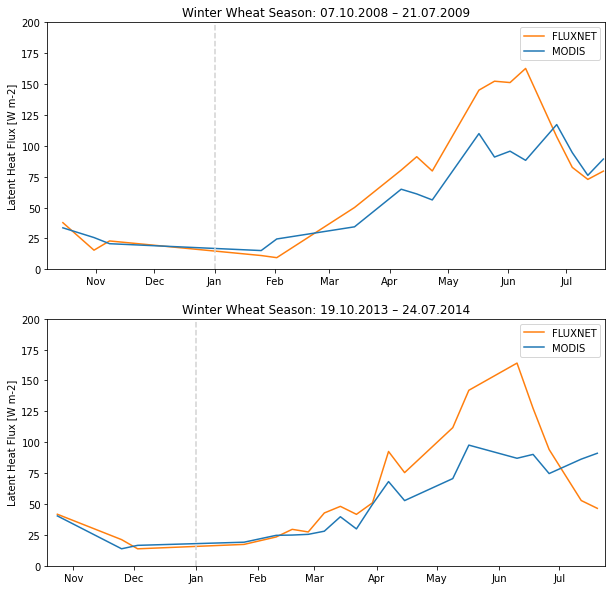

In [4]:
# Call the plot functions with the years to be plotted

oensingen.plot_values(2008, 2013, crop_type='Winter Wheat')

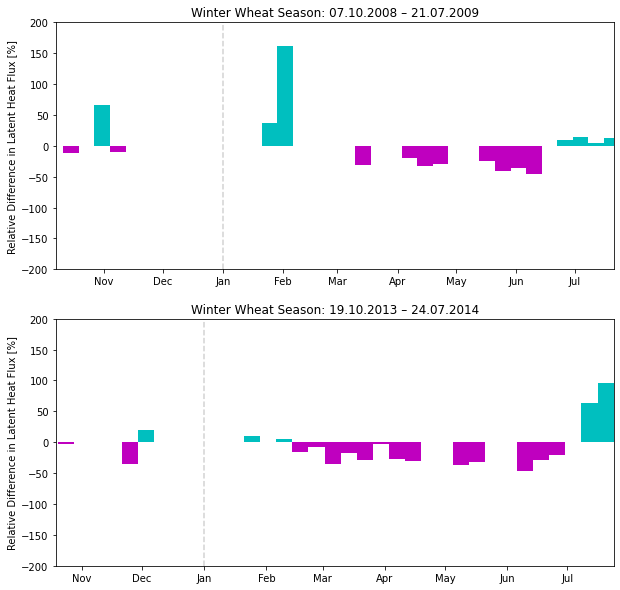

In [5]:
# Call the plot functions with the years to be plotted
#     mode: 'rel' or 'abs'
#     base: 'FLUXNET' or 'MODIS'

oensingen.plot_deltas(2008, 2013, crop_type='Winter Wheat', mode='rel', base='MODIS')

In [6]:
# Grignon data

crop_rotation = [
    ['Barley',['','02.07.2004']],
    ['Mustard',['02.09.2004','07.05.2005']],
    ['Maize',['09.05.2005','28.09.2005']],
    ['Winter Wheat',['28.10.2005','15.07.2006']],
    ['Barley',['04.10.2006','29.06.2007']],
    ['Mustard',['25.09.2007','14.04.2008']],
    ['Maize',['28.04.2008','10.09.2008']],
    ['Winter Wheat',['14.10.2008','31.07.2009']],
    ['Triticale',['20.10.2009','19.07.2010']],
    ['Phacelia',['14.09.2010','23.03.2011']],
    ['Maize',['21.04.2011','06.09.2011']],
    ['Winter Wheat',['20.10.2011','03.08.2012']],
    ['Rapeseed',['31.08.2012','06.08.2013']],
    ['Winter Wheat',['08.10.2013','05.08.2014']],
    ['Rapeseed',['10.09.2014','06.02.2015']],
    ['Maize',['16.04.2015','26.08.2015']],
    ['Winter Wheat',['20.10.2015','28.07.2016']],
    ['Rapeseed',['16.08.2016','29.07.2017']],
    ['Winter Wheat',['25.09.2017','08.07.2018']],
    ['Mixed CIPAN crops',['03.08.2018','15.04.2019']],
    ['Maize',['20.04.2019','16.09.2019']],
    ['Winter Wheat',['03.10.2019','10.07.2020']],
    ['Rapeseed',['20.08.2020','31.07.2021']],
    ['Winter Wheat',['07.10.2021','']]
]

FLUXNET_file_path = 'data/Grignon_FLUXNET/FLX_FR-Gri_FLUXNET2015_FULLSET_DD_2004-2014_1-4.csv'
MODIS_file_path = 'data/Grignon_MODIS/LE_500m_filtered_scaled.csv'

grignon = CropSiteData(FLUXNET_file_path, MODIS_file_path, crop_rotation)
    
print(f"Years available: {list(grignon.data['yearwise'].keys())}")
print()
for key, value in grignon.data['cropwise'].items():
    print(f"{key} – years available: {list(value.keys())}")

Years available: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]

Mustard – years available: [2004, 2007]
Maize – years available: [2005, 2008, 2011]
Winter Wheat – years available: [2005, 2008, 2011, 2013]
Barley – years available: [2006]
Triticale – years available: [2009]
Phacelia – years available: [2010]
Rapeseed – years available: [2012]
Mixed CIPAN crops – years available: []


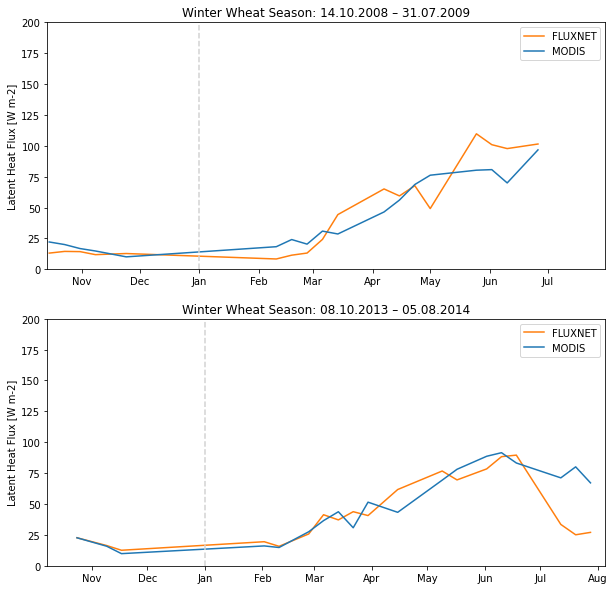

In [7]:
# Call the plot functions with the years to be plotted

grignon.plot_values(2008, 2013, crop_type='Winter Wheat')

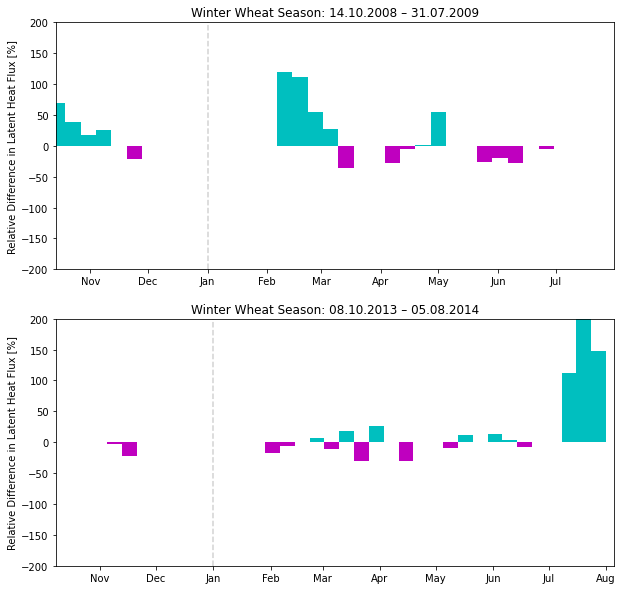

In [8]:
# Call the plot functions with the years to be plotted
#     mode: 'rel' or 'abs'
#     base: 'FLUXNET' or 'MODIS'

grignon.plot_deltas(2008, 2013, crop_type='Winter Wheat', mode='rel', base='MODIS')